In [15]:
import os
import time
import copy

import shutil

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

import torchvision
from torchvision import models, datasets, transforms
from torchvision.datasets import ImageFolder

from PIL import Image
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {DEVICE} for inference')

Using cuda for inference


#### Model Settings #####

In [16]:
TRAIN_SPLIT = 0.7
TEST_SPLIT = 0.3

LEARNING_RATE = 0.001

BATCH_SIZE = 128
NUM_EPOCHS = 3 # Increase to improve results

NUM_CLASSES = 2 # cat or dog

RANDOM_SEED = 1

torch.manual_seed(RANDOM_SEED)

##### Sort Dataset Into Folders ####

In [17]:
# I will split the training dataset into training and test (test = 30% of training data)

base_dir = "Cat Vs Dog Dataset"
train_dir = os.path.join(base_dir,"train")

if not os.path.exists(f"{train_dir}/cat"):
        os.makedirs(f"{train_dir}/cat")
        
if not os.path.exists(f"{train_dir}/dog"):
        os.makedirs(f"{train_dir}/dog")

# Sort cats and dog in Train dir into respective folders
onlyFilesinTrain = [filename for filename in os.listdir(train_dir) if not os.path.isdir(os.path.join(train_dir,filename))]

for filename in onlyFilesinTrain:
        
        label = filename.split(".")[0]
        
        if(label == "cat"):
                shutil.move(f"{train_dir}/{filename}" , f"{train_dir}/cat/{filename}")
                
        elif(label == "dog"):
                shutil.move(f"{train_dir}/{filename}" , f"{train_dir}/dog/{filename}")
        
        else:
                print("NO Label")



#### Load Data #####

In [18]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = datasets.ImageFolder(train_dir,transform=data_transform)

DATASET_SIZE = len(dataset)

train_data,test_data = random_split(dataset, [ int(TRAIN_SPLIT*DATASET_SIZE) , int(TEST_SPLIT*DATASET_SIZE)])

train_loader = DataLoader(dataset=train_data, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_data, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

CLASSES = dataset.classes  

#### Load Model ####

In [19]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print(resnet18.fc)

# we only need 2 classes need to cahnge ouput layer
resnet18.fc = nn.Linear(resnet18.fc.in_features,NUM_CLASSES)
print()
print(resnet18.fc)

# Make sure to send our model to GPU if available
resnet18 = resnet18.to(DEVICE)

Linear(in_features=512, out_features=1000, bias=True)

Linear(in_features=512, out_features=2, bias=True)


#### Compare True Label w/ Predicted Label #####

In [20]:
def compute_accuracy (model, data_loader, device):
    model = model.to(device)
    model = model.eval() # put the model to evaultion mode
    
    num_correct_prediction = 0
    num_total_labels = 0
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            probabilities = resnet18(inputs.to(DEVICE))
            predicted_class = torch.argmax(probabilities, dim=1) # Class predicted by model
            
            num_total_labels += labels.size()[0]
            num_correct_prediction += (predicted_class == labels).sum()

    return num_correct_prediction/num_total_labels * 100

#### Test w/o training ####

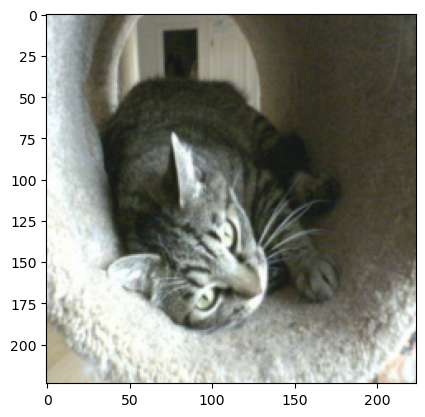

Predicted Class : dog
Actual Class : cat

Total Accuracy on test data : 60.507%


In [21]:
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    
img = torch.squeeze(inputs[0]).permute(1, 2, 0)
plt.imshow(img)
plt.show()


resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Class : {:s}".format(CLASSES[predicted_class.cpu()[0].item()]))
print("Actual Class : {:s}".format(CLASSES[labels.cpu()[0].item()]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))

#### Train Model ####

In [22]:
def train_model (model, data_loader, learning_rate, num_epochs, device):
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    
    start_time = time.time()
    
    for epochs in range(num_epochs):
        
        print("EPOCH : {0}/{1}".format(epochs+1,num_epochs))
        print("-"*30)
        
        # train first
        model.train()
        for batch_index, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)   
             
            probabilities = resnet18(inputs)
            predicted_class = torch.argmax(probabilities, dim=1)
            
            optimizer.zero_grad()
            loss = nn.functional.cross_entropy(probabilities,labels)
                
            loss.backward()
            optimizer.step()
            
            if (batch_index % 50 == 0) :
                print("BATCH : {:3d}/{:3d} | LOSS : {:.3f} ".format(batch_index,len(data_loader),loss))
            
        
        # evalute
        model.eval()
        with torch.set_grad_enabled(False):
            accuracy = compute_accuracy(model,data_loader,DEVICE)
            print("\nTotal Accuracy On Training Data : {:.3f}%".format(accuracy))
        
        # Save best weights
        if (accuracy > best_accuracy):
            best_accuracy = accuracy
            best_weights = copy.deepcopy(model.state_dict())
        
        print("Elapsed Time : {:.0f} min {:.0f} sec\n".format((time.time() - start_time)/60 , (time.time() - start_time)%60)) 
    
    print("\nTotal Time : {:.0f} min {:.0f} sec".format((time.time() - start_time)/60 , (time.time() - start_time)%60))
    
    
    model.load_state_dict(best_weights)
    return model

In [23]:
resnet18 = train_model(resnet18,train_loader,LEARNING_RATE,NUM_EPOCHS,DEVICE)

EPOCH : 1/3
------------------------------
BATCH :   0/137 | LOSS : 0.644 
BATCH :  50/137 | LOSS : 0.306 
BATCH : 100/137 | LOSS : 0.259 

Total Accuracy On Training Data : 95.731%
Elapsed Time : 2 min 56 sec

EPOCH : 2/3
------------------------------
BATCH :   0/137 | LOSS : 0.207 
BATCH :  50/137 | LOSS : 0.146 
BATCH : 100/137 | LOSS : 0.168 

Total Accuracy On Training Data : 97.200%
Elapsed Time : 4 min 53 sec

EPOCH : 3/3
------------------------------
BATCH :   0/137 | LOSS : 0.111 
BATCH :  50/137 | LOSS : 0.163 
BATCH : 100/137 | LOSS : 0.082 

Total Accuracy On Training Data : 97.651%
Elapsed Time : 6 min 52 sec


Total Time : 6 min 52 sec


### Test w/ Training ###

In [24]:
"""
for batch_index, (inputs, labels) in enumerate(test_loader):

    inputs = inputs
    labels = labels
    break
    
 
img = torch.squeeze(inputs[1]).permute(1, 2, 0)
plt.imshow(img)
plt.show()

resnet18 = resnet18.eval()

with torch.no_grad(): # Save Performance when evaluting or prediciting
    probabilities = resnet18(inputs.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Class : {:s}".format(CLASSES[predicted_class.cpu()[1].item()]))
print("Actual Class : {:s}".format(CLASSES[labels.cpu()[1].item()]))
print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))
"""

'\nfor batch_index, (inputs, labels) in enumerate(test_loader):\n\n    inputs = inputs\n    labels = labels\n    break\n    \n \nimg = torch.squeeze(inputs[1]).permute(1, 2, 0)\nplt.imshow(img)\nplt.show()\n\nresnet18 = resnet18.eval()\n\nwith torch.no_grad(): # Save Performance when evaluting or prediciting\n    probabilities = resnet18(inputs.to(DEVICE))\n    predicted_class = torch.argmax(probabilities, dim=1)\n\nprint("Predicted Class : {:s}".format(CLASSES[predicted_class.cpu()[1].item()]))\nprint("Actual Class : {:s}".format(CLASSES[labels.cpu()[1].item()]))\nprint("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))\n'

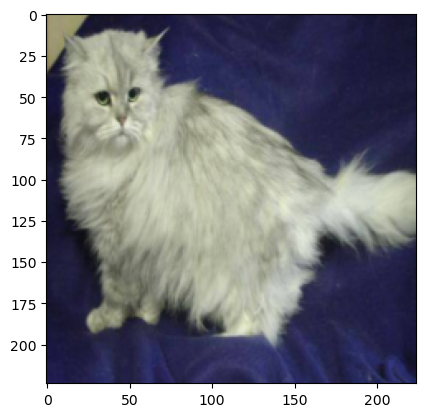

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [25]:
features = torch.empty(0)
true_label = torch.empty(0)

for batch_index, (inputs, labels) in enumerate(test_loader):

    features = torch.cat((features,inputs))
    true_label = torch.cat((true_label,labels))
    
img = torch.squeeze(features[1]).permute(1, 2, 0)
plt.imshow(img)
plt.show()


resnet18 = resnet18.eval()

with torch.no_grad():
    probabilities = resnet18(features.to(DEVICE))
    predicted_class = torch.argmax(probabilities, dim=1)

print("Predicted Class : {:.0f}".format(CLASSES[predicted_class.cpu()[1].item()]))
print("Actual Class : {:.0f}".format(CLASSES[labels.cpu()[1].item()]))

print("\nTotal Accuracy on test data : {:.3f}%".format(compute_accuracy(resnet18,test_loader,DEVICE)))